In [1]:
import os
import sys
sys.path.append('..')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from utils.base_model import Base3DCNN, Enhanced3DCNN
from utils.data_loader import get_medmnist_dataloaders
from utils.trainer import Trainer
from utils.metrics import evaluate_model, compute_metrics
from utils.visualization import plot_training_history, plot_confusion_matrix
from config import *

print(f"Device: {DEVICE}")
set_seed(42)

Device: cuda


In [2]:
# Load OrganMNIST3D dataset
train_loader, val_loader, test_loader, num_classes = get_medmnist_dataloaders(
    dataset_name='organ',
    batch_size=DATA_CONFIG['batch_size'],
    num_workers=DATA_CONFIG['num_workers']
)

print(f"Number of classes: {num_classes}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Using downloaded and verified file: /home/luca/.medmnist/organmnist3d.npz
Number of classes: 11
Training batches: 31
Validation batches: 6
Test batches: 20


In [3]:
# Initialize model with architecture options
from utils.cnn_3d_models import get_3d_model

architecture = MODEL_CONFIG['architecture']

# Create model based on architecture
if architecture in ['resnet18_3d', 'resnet34_3d', 'resnet50_3d', 'densenet121_3d', 'efficientnet3d_b0']:
    model = get_3d_model(
        model_name=architecture,
        num_classes=num_classes,
        dropout_rate=MODEL_CONFIG['dropout_rate']
    )
    print(f"Using {architecture.upper().replace('_', '-')}")
elif architecture == 'enhanced':
    model = Enhanced3DCNN(
        in_channels=1,
        num_classes=num_classes,
        dropout_rate=MODEL_CONFIG['dropout_rate']
    )
    print(f"Using Enhanced3DCNN")
else:
    # Default: Base3DCNN
    model = Base3DCNN(
        in_channels=1,
        num_classes=num_classes,
        dropout_rate=MODEL_CONFIG['dropout_rate']
    )
    print(f"Using Base3DCNN")

model = model.to(DEVICE)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nModel Architecture: {architecture}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"\nTo change architecture, edit MODEL_CONFIG['architecture'] in config.py")
print(f"   Options: 'base', 'enhanced', 'resnet18_3d', 'resnet34_3d', 'resnet50_3d',")
print(f"            'densenet121_3d', 'efficientnet3d_b0'")

Using EFFICIENTNET3D-B0

Model Architecture: efficientnet3d_b0
Total parameters: 1,219,595
Trainable parameters: 1,219,595

To change architecture, edit MODEL_CONFIG['architecture'] in config.py
   Options: 'base', 'enhanced', 'resnet18_3d', 'resnet34_3d', 'resnet50_3d',
            'densenet121_3d', 'efficientnet3d_b0'


In [4]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=TRAINING_CONFIG['learning_rate'],
    weight_decay=TRAINING_CONFIG['weight_decay']
)
scheduler = StepLR(
    optimizer,
    step_size=TRAINING_CONFIG['scheduler_step_size'],
    gamma=TRAINING_CONFIG['scheduler_gamma']
)

# Create trainer
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler
)

print("Training setup complete!")

Training setup complete!


In [5]:
# Train the model
num_epochs = 30
print(f"Training for {num_epochs} epochs...\n")

history = trainer.train(num_epochs=num_epochs)

print("\n" + "="*50)
print("Training completed!")
print(f"Best validation accuracy: {max(history['val_acc']):.4f}")
print("="*50)

Training for 30 epochs...


Epoch 1/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 25.24it/s]


Train Loss: 2.0392, Train Acc: 0.2410
Val Loss: 3.8560, Val Acc: 0.0994
New best validation accuracy: 0.0994

Epoch 2/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.59it/s]


Train Loss: 1.4113, Train Acc: 0.4501
Val Loss: 4.6024, Val Acc: 0.0994

Epoch 3/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.88it/s]


Train Loss: 0.8899, Train Acc: 0.6921
Val Loss: 0.3715, Val Acc: 0.8882
New best validation accuracy: 0.8882

Epoch 4/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 29.39it/s]


Train Loss: 0.6341, Train Acc: 0.7693
Val Loss: 0.3495, Val Acc: 0.8758

Epoch 5/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.57it/s]


Train Loss: 0.5151, Train Acc: 0.8198
Val Loss: 0.1869, Val Acc: 0.9503
New best validation accuracy: 0.9503

Epoch 6/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 28.08it/s]


Train Loss: 0.3631, Train Acc: 0.8733
Val Loss: 0.1509, Val Acc: 0.9627
New best validation accuracy: 0.9627

Epoch 7/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.13it/s]


Train Loss: 0.4288, Train Acc: 0.8558
Val Loss: 0.3293, Val Acc: 0.9130

Epoch 8/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.70it/s]


Train Loss: 0.3351, Train Acc: 0.8929
Val Loss: 0.1241, Val Acc: 0.9565

Epoch 9/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.19it/s]


Train Loss: 0.2799, Train Acc: 0.9114
Val Loss: 0.2660, Val Acc: 0.9068

Epoch 10/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 28.25it/s]


Train Loss: 0.2239, Train Acc: 0.9248
Val Loss: 0.1317, Val Acc: 0.9627

Epoch 11/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.39it/s]


Train Loss: 0.1567, Train Acc: 0.9516
Val Loss: 0.1011, Val Acc: 0.9814
New best validation accuracy: 0.9814

Epoch 12/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.42it/s]


Train Loss: 0.1355, Train Acc: 0.9598
Val Loss: 0.0858, Val Acc: 0.9814

Epoch 13/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.34it/s]


Train Loss: 0.0737, Train Acc: 0.9753
Val Loss: 0.1216, Val Acc: 0.9876
New best validation accuracy: 0.9876

Epoch 14/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.90it/s]


Train Loss: 0.0744, Train Acc: 0.9712
Val Loss: 0.1006, Val Acc: 0.9814

Epoch 15/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.44it/s]


Train Loss: 0.0548, Train Acc: 0.9835
Val Loss: 0.0758, Val Acc: 0.9814

Epoch 16/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.22it/s]


Train Loss: 0.0540, Train Acc: 0.9846
Val Loss: 0.0805, Val Acc: 0.9876

Epoch 17/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 29.27it/s]


Train Loss: 0.0760, Train Acc: 0.9722
Val Loss: 0.1234, Val Acc: 0.9689

Epoch 18/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.95it/s]


Train Loss: 0.0870, Train Acc: 0.9691
Val Loss: 0.0723, Val Acc: 0.9876

Epoch 19/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 28.60it/s]


Train Loss: 0.0865, Train Acc: 0.9712
Val Loss: 0.0713, Val Acc: 0.9876

Epoch 20/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 29.90it/s]


Train Loss: 0.0952, Train Acc: 0.9681
Val Loss: 0.1623, Val Acc: 0.9627

Epoch 21/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 28.40it/s]


Train Loss: 0.0541, Train Acc: 0.9825
Val Loss: 0.1059, Val Acc: 0.9752

Epoch 22/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.79it/s]


Train Loss: 0.0285, Train Acc: 0.9918
Val Loss: 0.1132, Val Acc: 0.9814

Epoch 23/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 26.64it/s]


Train Loss: 0.0229, Train Acc: 0.9938
Val Loss: 0.0806, Val Acc: 0.9876

Epoch 24/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.74it/s]


Train Loss: 0.0253, Train Acc: 0.9928
Val Loss: 0.0773, Val Acc: 0.9876

Epoch 25/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 24.68it/s]


Train Loss: 0.0252, Train Acc: 0.9928
Val Loss: 0.1075, Val Acc: 0.9876

Epoch 26/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.88it/s]


Train Loss: 0.0251, Train Acc: 0.9949
Val Loss: 0.0921, Val Acc: 0.9876

Epoch 27/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.22it/s]


Train Loss: 0.0197, Train Acc: 0.9938
Val Loss: 0.0932, Val Acc: 0.9814

Epoch 28/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.11it/s]


Train Loss: 0.0232, Train Acc: 0.9949
Val Loss: 0.0769, Val Acc: 0.9876

Epoch 29/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 27.72it/s]


Train Loss: 0.0497, Train Acc: 0.9856
Val Loss: 0.0726, Val Acc: 0.9814

Epoch 30/30


Validation: 100%|██████████| 6/6 [00:00<00:00, 29.15it/s]

Train Loss: 0.0307, Train Acc: 0.9887
Val Loss: 0.0657, Val Acc: 0.9814

Training completed!
Best validation accuracy: 0.9876


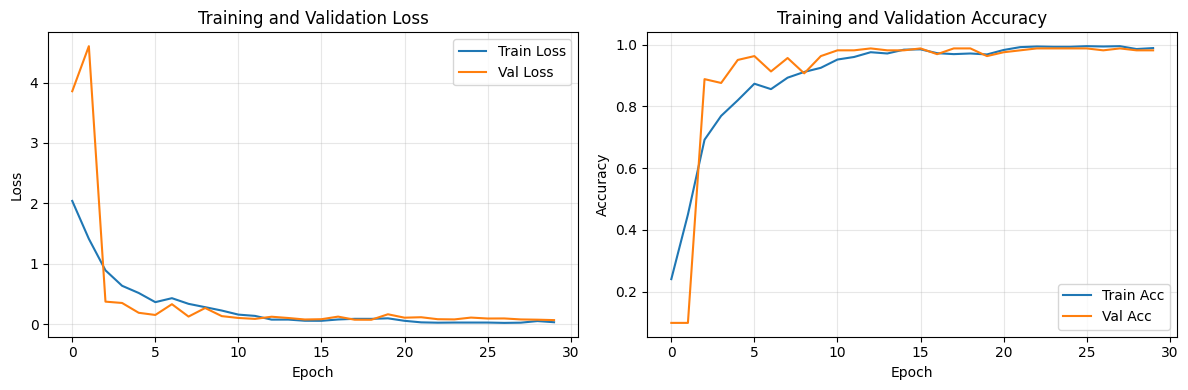

In [6]:

# Define the path
save_path = '../figures/baseline_training_history.png'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Plot and save
plot_training_history(history, save_path=save_path)

In [7]:
# Evaluate on test set
print("Evaluating on test set...\n")
test_metrics, test_preds, test_labels = evaluate_model(model, test_loader, DEVICE)

print("Test Set Results:")
print(f"  Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"  Precision: {test_metrics['precision']:.4f}")
print(f"  Recall:    {test_metrics['recall']:.4f}")
print(f"  F1-Score:  {test_metrics['f1_score']:.4f}")

print("\nPer-class metrics:")
for i, organ_name in ORGAN_CLASSES.items():
    if i < len(test_metrics['per_class']['f1_score']):
        f1 = test_metrics['per_class']['f1_score'][i]
        print(f"  {organ_name:15s}: F1={f1:.4f}")

Evaluating on test set...

Test Set Results:
  Accuracy:  0.8672
  Precision: 0.8798
  Recall:    0.8672
  F1-Score:  0.8694

Per-class metrics:
  bladder        : F1=0.9784
  femur-left     : F1=0.7559
  femur-right    : F1=0.7160
  heart          : F1=0.8986
  kidney-left    : F1=0.8504
  kidney-right   : F1=0.9091
  liver          : F1=0.9231
  lung-left      : F1=1.0000
  lung-right     : F1=0.9302
  pancreas       : F1=0.8800
  spleen         : F1=0.8872


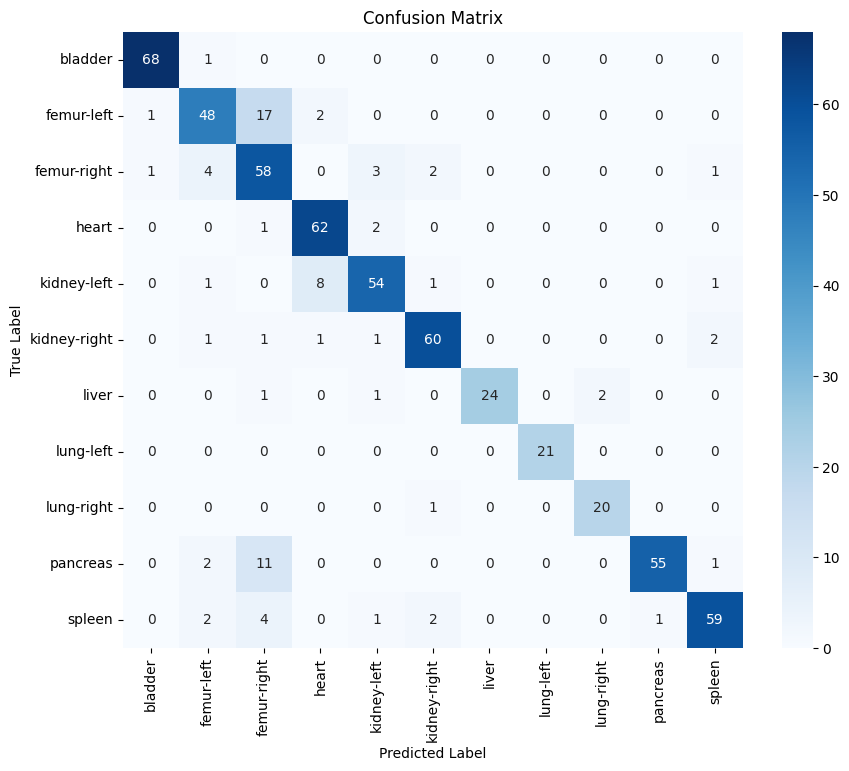

In [8]:
# Plot confusion matrix
class_names = [ORGAN_CLASSES[i] for i in range(num_classes)]
plot_confusion_matrix(
    test_metrics['confusion_matrix'],
    class_names=class_names,
    save_path='../figures/baseline_confusion_matrix.png'
)

In [9]:
# Save trained model
import os
os.makedirs('../models', exist_ok=True)

model_filename = f'../models/{architecture}_baseline.pth'

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'history': history,
    'test_metrics': test_metrics,
    'num_classes': num_classes,
}, model_filename)

print(f"Model saved to '{model_filename}'")

Model saved to '../models/efficientnet3d_b0_baseline.pth'
